In [1]:
# Setting up

# Import required modules
import glob
import scipy.io as sio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import sklearn

# Store the path of the folder containing the data
# Alternatively, could use user input - 
# path = input('Enter the file path of the data: ')
path = '/Users/AV/Dropbox/UCLA/cfgData/'

# Need to alphabetise and store the filenames in the path
TS_path_names = sorted(glob.glob(path + '*.mat'))


In [2]:
# Reading in the feature matrix data from the .txt file

# Import and store the feature matrix in the variable tsData
filePath = '/Users/AV/Desktop/FeatureMatrixData/element1.txt'
tsData = pd.read_csv(filePath,header=None);

In [3]:
# Creating the target column

# This function, when called, prompts the user to input a string
# which can be used to uniquely identify any SCZ data file
# It returns a binary target column (0 = control, 1 = SCZ)

def getTargetCol():
    
    # string = input('Enter a string found in all filenames that only contain SCZ data: ')
    string = '-5'
    # In this case '-5' should do
    
    # Initialise and format a target column of length TS_path_names
    x = np.zeros(len(TS_path_names))
    x = x.astype(int)
    Diagnosis = np.reshape(x,(len(TS_path_names),1))

    # Initialise an index
    i = 0

    for path in TS_path_names:
        if string in path:
            # If the string is found, the data must be from a SCZ patient
            Diagnosis[i] = 1
            # Increment index
            i += 1
        else:
            # Increment index
            i += 1
    return Diagnosis

targetCol = getTargetCol()

In [4]:
# ROI selection

# This function takes a ROI as an input and gets the relevant slice (or rows) from tsData

def getROISlice(ROI):
    
#     ROI = input('Which ROI is being analysed?: ')
    
    # Initialise a boolean
    validROI = False
    
    while validROI == False:
    
        # Rows per region of interest = len(TS_path_names)
        rowsPerROI = len(TS_path_names)
        [rows,cols] = tsData.shape

        # Get the rows corresponding to the mth region of interest
        Slice = tsData.iloc[((int(ROI)-1)*rowsPerROI):(int(ROI)*rowsPerROI),:]

        # Assigning min and max values for input 'm'
        minROI = 1
        maxROI = int(rows/rowsPerROI)

        if minROI <= int(ROI) <= maxROI:
            validROI == True
            return Slice, ROI, maxROI
#         else:
#             print('Error: Please select a ROI between ' + str(minROI) + ' and ' + str(maxROI))
#             print('')
#             ROI = input('Which ROI is being analysed?: ')
            
# Need to z-score the selection of tsData
from scipy.stats import zscore
tsDataSlice, ROI, maxROI = getROISlice(1)

tsDataSlice_zscored = tsDataSlice.apply(zscore)

# Assign the data to variables
X = tsDataSlice_zscored
y = np.ravel(targetCol)

In [5]:
# Need to store the data as a 3D feature matrix which will allow access to relevant slices
# [rows,cols,layers] = i, j, k = 185, 22, ROIs - varies element to element

featMat3D = np.zeros((len(TS_path_names),22,maxROI))

# Loop through each slice and store it in the matrix
for i in range(1, maxROI+1):
    featMat3D[:,:,i-1] = getROISlice(i)[0]

def getFeatSlice(feat):
    Slice = featMat3D[:,abs(feat-1),:]
    return Slice

In [6]:
# Perform 10-Fold Cross Validation

# This function...

def get10FoldCVScore(X,y):

    # Split the data into training and test sets
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10)

    # Import the support vector classifier and find the best fit using the training data
    from sklearn.svm import SVC
    svclassifier = SVC(kernel='linear', class_weight = 'balanced')
    svclassifier.fit(X_train, y_train)

    # Using the SVC derived from fitting to the training set, classify the test set
    # and store this in a variable
    y_pred = svclassifier.predict(X_test)

    # Performing a 10-fold validation using cross_val_score
    from sklearn.model_selection import cross_val_score, KFold

    # DO NOT WANT TO SHUFFLE THE DATA
    kf = KFold(n_splits=10, shuffle=False)

    scores = cross_val_score(svclassifier, X, y, cv=kf) * 100
    scores = scores.astype(int)
    
    return scores

# # Store the function's output as a variable
# scores = get10FoldCVScore(X,y)

# # Print scores
# print('10-fold CV scores as a percentage: ' + str(scores))
# print('')

# # Mean 10-fold CV score with an error of 1 std dev
# print("Accuracy as a percentage: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

In [7]:
# Compute the t-values (from a two-tail t-test) and the p-values
# Store these two values (t-value, then p-value) in each row, 22 in total for each feature

# This function...

def getTPVals():
    
    from scipy.stats import stats,ttest_ind

    # Initialise the array and assign its shape
    tpValArray = np.zeros([22, 2])
    [rows, cols] = tpValArray.shape

    # Make a custom range of rows which can be used to distinguish the control data from the SCZ data
    # Find all instances of 0 in the target column (which would indicate control data)
    # and store the indices in an array
    global targetCol
    a = np.where(targetCol == 0)[0]
    aStart = a[0]
    aEnd = a[-1] + 1

    # Find all instances of 1 in the target column (which would indicate SCZ data)
    # and store the indices in an array
    b = np.where(targetCol == 1)[0]
    bStart = b[0]
    bEnd = b[-1] + 1

    # Loop through the array and store the t and p values
    for i in range(rows):

        # Calculate the t and p values by inputting the two halves of each of the 22 columns
        # of the normalised data into the ttest functions
        # Store the statistics in the variable, tpVal (which changes on each iteration of the outer loop)
        global tsDataSlice
        controlFeatCol = tsDataSlice.iloc[aStart:aEnd,i]
        SCZFeatCol = tsDataSlice.iloc[bStart:bEnd,i]
        tpVal = stats.ttest_ind(controlFeatCol, SCZFeatCol)

        for j in range(cols):

            # Store the values into each column
            tpValArray[i,j] = tpVal[j]

    # Since it is a two-tailed t-test, need to multiply the p-values by two (second column)
    tpValArray[:,1] = tpValArray[:,1] * 2

    # Formatting the tpValArray
    tpValDf = pd.DataFrame(data=tpValArray, columns=['t-value', 'p-value'])
    tpValDf.index.name = 'Feature i'

    # Sort the data (including the indices) in descending order by MAGNITUDE
    tpValDf_sorted = tpValDf.abs().sort_values(by='t-value',ascending=False)

    # Store the first five indices of the sorted dataframe - will need to use these
    # indices to access the relevant feature columns in X, the feature matrix
    indexVals = tpValDf_sorted.index.values
    signifTVals = indexVals[:5]

    return tpValDf, tpValDf_sorted, signifTVals

# Store the function's outputs
tpValDf, tpValDf_sorted, signifTVals = getTPVals()

# print(tpValDf)
# print('')
# print(tpValDf_sorted)
# print('')
# print(signifTVals)
# print('')

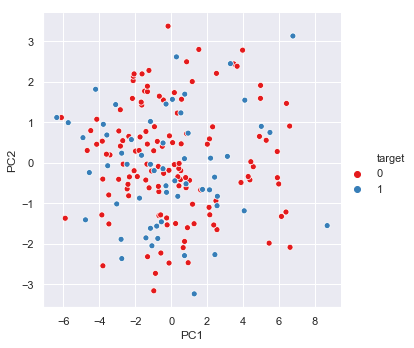

In [8]:
# PCA

# This function...

def showMePCAFig():
    
    from sklearn.preprocessing import StandardScaler

    # Standardizing the features
    x = StandardScaler().fit_transform(tsDataSlice)

    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data=principalComponents
                 , columns=['PC1', 'PC2'])

    targetCol_df = pd.DataFrame(data=targetCol, columns=['target'])

    finalDf = pd.concat([principalDf, targetCol_df], axis = 1)

    # print(finalDf)

    # Plotting the PCA scatterplot using Seaborn
    sns.set()
    ax = sns.relplot(x='PC1', y='PC2', data=finalDf, hue='target',palette='Set1')
    plt.show()
    return

showMePCAFig()

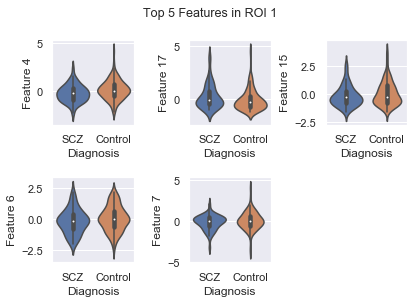

In [9]:
# Violin plots

# This function...

def showMeViolinPlts():

    # Create an index for the subplot
    n = 1;

    fig = plt.figure()

    global targetCol, signifTVals, X, ROI

    # Copy pasted (code enables custom selection of rows)
    a = np.where(targetCol == 0)[0]
    aStart = a[0]
    aEnd = a[-1] + 1

    b = np.where(targetCol == 1)[0]
    bStart = b[0]
    bEnd = b[-1] + 1
    
    for i in signifTVals:
        # Obtain control feature i and SCZ feature i (all the rows)
        # from the ith column of the z-scored feature matrix
        cf_i = X.iloc[aStart:aEnd,i]
        sf_i = X.iloc[bStart:bEnd,i]

        # Convert into a dataframe
        df_feat_i = pd.DataFrame({'SCZ':sf_i,'Control':cf_i})

        # Violin plots
        ax = fig.add_subplot(2,3,n)
        ax = sns.violinplot(data=df_feat_i, order=['SCZ','Control'])
        plt.xlabel('Diagnosis')
        ylabel = 'Feature ' + str(i)
        plt.ylabel(ylabel)
        
        # Increment index
        n += 1;
    
    plt.suptitle('Top 5 Features in ROI ' + str(ROI), fontsize=12.5, y=1.05)
    plt.tight_layout()
    plt.show()
    return

showMeViolinPlts()

Region  % Accuracy
    35        61.9
   280        61.9
    55        61.3
   250        61.1
   257        60.9

Mean Accuracy (across all regions) = 50.75%



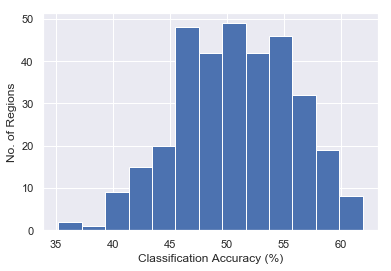

In [10]:
# Plotting the number of regions with classification accuracies greater than 60%

regions = np.zeros([maxROI])
region_acc = np.zeros([maxROI])

def showMeRegAccPlot():
    
    global maxROI
    for n in range(1, maxROI+1):
        
        tsDataSlice = getROISlice(n)[0]
        tsDataSlice_zscored = tsDataSlice.apply(zscore)

        # Assign the data to variables
        X = tsDataSlice_zscored
        y = np.ravel(targetCol)

        avgScore = get10FoldCVScore(X,y).mean()
        regions[n-1] = n
        region_acc[n-1] = avgScore

    df = pd.DataFrame({'Region':regions,'% Accuracy':region_acc})
    df['Region'] = df.Region.astype(int)

    df_sorted = df.sort_values(by='% Accuracy',ascending=False)
    print(df_sorted[:5].to_string(index=False))
    print('')
    
    print('Mean Accuracy (across all regions) = ' + "{0:.2f}".format(df['% Accuracy'].mean()) + '%')
    print('')
    
    plt.hist(region_acc, bins='auto')
    plt.xlabel('Classification Accuracy (%)')
    plt.ylabel('No. of Regions')
    plt.show()
    return

# Call the function to test
showMeRegAccPlot()

Feature  % Accuracy
     11        61.4
      3        59.5
     17        58.9
      1        58.6
     14        58.0

Mean Accuracy (across all features) = 54.11%



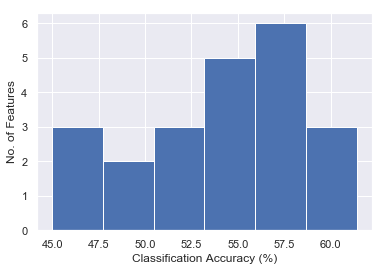

In [11]:
# Plot feature accuracies

feats = np.zeros(22)
feat_acc = np.zeros(22)

def showMeFeatAccPlot():
    
    for n in range(1, 23):
        
        tsDataSlice = pd.DataFrame(getFeatSlice(n))
        tsDataSlice_zscored = tsDataSlice.apply(zscore)

        # Assign the data to variables
        X = tsDataSlice_zscored
        y = np.ravel(targetCol)

        avgScore = get10FoldCVScore(X,y).mean()
        feats[n-1] = n
        feat_acc[n-1] = avgScore

    df = pd.DataFrame({'Feature':feats,'% Accuracy':feat_acc})
    df['Feature'] = df.Feature.astype(int)

    df_sorted = df.sort_values(by='% Accuracy',ascending=False)
    print(df_sorted[:5].to_string(index=False))
    print('')
    
    print('Mean Accuracy (across all features) = ' + "{0:.2f}".format(df['% Accuracy'].mean()) + '%')
    print('')
    
    plt.hist(feat_acc, bins='auto')
    plt.xlabel('Classification Accuracy (%)')
    plt.ylabel('No. of Features')
    plt.show()
    return

# Call the function to test
showMeFeatAccPlot()